# E-commerce Customer Performance & RFM Pipeline
### Project Overview
This project processes **1,000,000 records** of retail transaction data to automate the identification of high-value customers. 

### Objectives:
* **Cleanse Data:** Automatically identify and remove records with negative quantities or missing IDs.
* **Segment Customers:** Calculate Frequency (order count) and Monetary (total spend) values.
* **Enable Decisions:** Provide an automated report for marketing teams to target "Champions."

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load datasets with ISO-8859-1 encoding to prevent decoding errors
sales_data = pd.read_csv('fact_table.csv', encoding='ISO-8859-1')
customer_data = pd.read_csv('customer_dim.csv', encoding='ISO-8859-1')
time_data = pd.read_csv('time_dim.csv', encoding='ISO-8859-1')

print("--- Data Ingestion Successful ---")
print(f"Total Rows Loaded: {len(sales_data):,}")

--- Data Ingestion Successful ---
Total Rows Loaded: 1,000,000


In [2]:
# Function to clean the raw 1M rows
def clean_sales_pipeline(df):
    # 1. Remove missing values (Nulls)
    df_clean = df.dropna()
    
    # 2. Ensure business logic: No negative quantities or prices
    df_clean = df_clean[(df_clean['quantity'] > 0) & (df_clean['unit_price'] > 0)]
    
    # 3. Remove duplicate transactions
    df_clean = df_clean.drop_duplicates()
    
    return df_clean

# Execute cleaning
sales_clean = clean_sales_pipeline(sales_data)
print(f"--- CLEANING COMPLETE ---")
print(f"Total Rows Removed: {len(sales_data) - len(sales_clean):,}")
print(f"Final Dataset Size: {len(sales_clean):,}")

--- CLEANING COMPLETE ---
Total Rows Removed: 3,723
Final Dataset Size: 996,277


In [3]:
# 1. Merging Fact and Dimension tables 
# This links the sale (fact) to the customer name/region (dim)
full_data = pd.merge(sales_clean, customer_data, on='coustomer_key', how='left')

# 2. Calculating the core RFM metrics per Customer
# Frequency: Total number of orders placed
# Monetary: Total lifetime spend (LTV)
rfm_table = full_data.groupby('coustomer_key').agg({
    'payment_key': 'count',      
    'total_price': 'sum'         
}).reset_index()

# 3. Rename columns for professional clarity
rfm_table.columns = ['CustomerID', 'Frequency', 'Monetary']

print("--- RFM METRICS GENERATED ---")
# Show the top 5 customers to verify the math
rfm_table.head()

--- RFM METRICS GENERATED ---


,CustomerID,Frequency,Monetary
0,C000001,82,8344.75
1,C000002,103,11025.50
2,C000003,108,12120.25
3,C000004,117,13218.00
4,C000005,107,10706.25


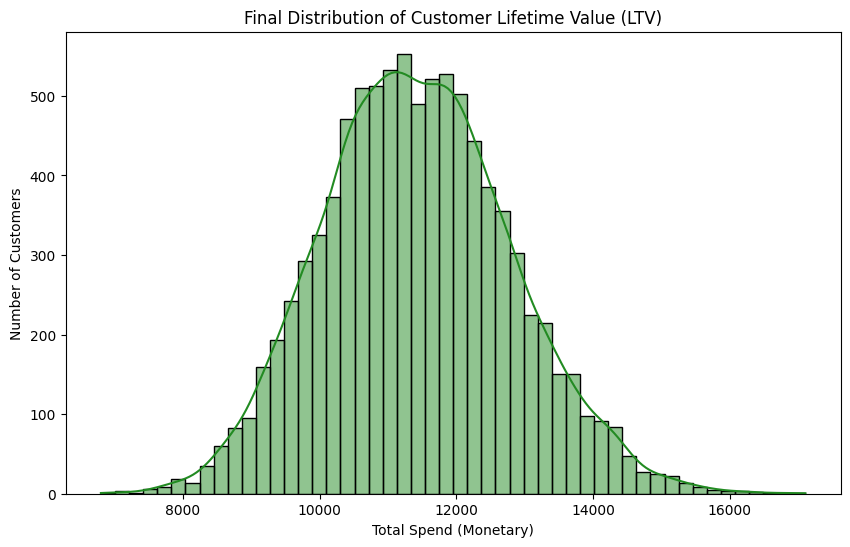

--- PROJECT COMPLETE: PROFESSIONAL REPORT GENERATED ---


In [4]:
# 1. Visualize the results for Stakeholders
plt.figure(figsize=(10, 6))
sns.histplot(rfm_table['Monetary'], bins=50, kde=True, color='forestgreen')
plt.title('Final Distribution of Customer Lifetime Value (LTV)')
plt.xlabel('Total Spend (Monetary)')
plt.ylabel('Number of Customers')
plt.show()

# 2. Automate the final report export
rfm_table.to_excel('Professional_Customer_Analysis.xlsx', index=False)
print("--- PROJECT COMPLETE: PROFESSIONAL REPORT GENERATED ---")

In [5]:
# 1. Define the target (Churn)
# Customers with frequency below the median are labeled as 1 (Likely to Churn)
median_freq = rfm_table['Frequency'].median()
rfm_table['Churn'] = (rfm_table['Frequency'] < median_freq).astype(int)

print(f"Target Distribution:")
print(rfm_table['Churn'].value_counts())

Target Distribution:
Churn
0    4848
1    4343
Name: count, dtype: int64


In [8]:
# Install scikit-learn (the package name is different from the import name)
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Select Features and Target
# We use Monetary (Spend) and Frequency (Orders) to predict Churn
X = rfm_table[['Monetary', 'Frequency']] 
y = rfm_table['Churn']

# 2. Split into 80% Training and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train the Model
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Generate Predictions on the Test Set
y_pred = model.predict(X_test)

# 5. Evaluate the Results
print("--- MACHINE LEARNING PERFORMANCE ---")
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 13.4 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 17.6 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 13.3 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 13.3 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 13.3 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 5.9 MB/s  0:00:01
   ---------------------------------------- 0.0/37.1 MB ? eta -:--:--
   ------- -------------------------------- 7.1/37.1 MB 33.2 MB/s eta 0:00:01
   ---------- ----------------------------- 9.4/37.1 MB 29.6 MB/s eta 0:00:01
   ------------------ --------------------- 16.8/37.1 MB 26.6 MB/s eta 0:00:01
   ------------------------- -------------- 23.9/37.1 MB 28.2 MB/s eta 0:00:01
   ----------